# Clustering

How can we "cluster" texts together based on similar vocabulary, or other features we calculate?

## Preliminaries

In [2]:
# import some things
import os
import pandas as pd
from textblob import TextBlob
from matplotlib import pyplot as plt
pd.set_option("display.max_rows", 20)

In [3]:
# Set text folder and metadata path

text_folder = '../corpora/peregrine'
path_to_metadata='../corpora/peregrine/peregrine.csv'

In [12]:
import csv
seasons = {
    "oct" : "fall",
    "nov" : "fall",
    "dec" : "winter",
    "jan" : "winter",
    "feb" : "winter",
    "mar" : "spring",
    "apr" : "spring"
}

fns = os.listdir('../corpora/peregrine')
with open('../corpora/peregrine/peregrine.csv', mode='w') as metadata:
    metadata.write("fn,season\n")
    for fn in fns:
        if(fn=="the-hunting-life.txt"):
            metadata.write(str(fn)+","+"all\n")
        elif(fn[-4:]==".txt"):
            metadata.write(str(fn)+","+seasons[str(fn)[:3]]+'\n')

In [17]:
# Load metadata
df_meta = pd.read_csv(path_to_metadata)
df_meta

,fn,season
0,feb-22.txt,winter
1,mar-5.txt,spring
2,dec-18.txt,winter
3,oct-26.txt,fall
4,dec-24.txt,winter
5,nov-11.txt,fall
6,nov-13.txt,fall
7,mar-6.txt,spring
8,oct-30.txt,fall
9,oct-24.txt,fall


In [18]:
# Let's also set the 'label' as the index
df_meta=df_meta.set_index('fn',drop=False)    # drop=False means that 'label' is preserved as a column, as well as acting as the new index
df_meta

,fn,season
fn,,
feb-22.txt,feb-22.txt,winter
mar-5.txt,mar-5.txt,spring
dec-18.txt,dec-18.txt,winter
oct-26.txt,oct-26.txt,fall
dec-24.txt,dec-24.txt,winter
nov-11.txt,nov-11.txt,fall
nov-13.txt,nov-13.txt,fall
mar-6.txt,mar-6.txt,spring
oct-30.txt,oct-30.txt,fall


In [19]:
# A function to make a document-term matrix
# FROM a df_meta object

def make_dtm_from_df(df_meta,n_top_words=1000,normalize=True,filename_col='fn',no_cap_words=True,exclude_words=[]):
    # get stopwords
    stopwords=exclude_words
    stopwords=set(stopwords)

    # make an empty results list
    all_results = []

    # make a count for all words
    from collections import Counter
    all_counts = Counter()

    # for each filename
    for i,fn in enumerate(df_meta[filename_col]):
        if not i%10: print('>> looping through #',i,'of',len(df_meta),'files:',fn)
        # make sure is a text file
        if not fn.endswith('.txt'): continue
        
        # full path
        full_path = os.path.join(text_folder,fn)

        # open the file
        with open(full_path) as file:
            txt=file.read()

        # make a blob
        blob = TextBlob(txt)

        # make a result dictionary
        text_result = {}

        # set the filename and index
        text_result['fn']=fn
        text_result['index']=df_meta.index[i]

        # loop over the word counts
        num_words = len(blob.words)
        
        from collections import Counter
        word_counts = Counter(blob.words)

        # for each word,count pair in the blob.word_counts dictionary...
        for word,count in word_counts.items():
            # is the word in the stopwords?
            if word in stopwords: continue  
                
            # skip capitalized words?
            if no_cap_words and word!=word.lower(): continue
                
            # lowercase word
            word = word.lower()

            # is the word a punctuation?
            if not word[0].isalpha(): continue
            
            # set the normalized version
            if normalize:
                # get the term frequency (count divided by number of words)
                tf = count / num_words

                # set the term frequency result to the key 'word' in the text_result dictionary
                text_result[word] = tf
            else:
                # set the count as a result
                text_result[word] = count

            # add the count to the dictionary of counts for all words
            all_counts[word]+=count

        # add results
        all_results.append(text_result)
    
    # Get the most frequent words
    most_common_words_plus_counts = all_counts.most_common(n_top_words)
    
    # Get only the words
    word_columns = []
    for word,count in most_common_words_plus_counts:
        word_columns.append(word)
        
    # Words used as columns
    print('>> top',n_top_words,'words:',word_columns)
    
    # Get columns
    columns=[]
    #columns.append('fn')
    columns.append('index')
    columns.extend(word_columns)
    
    # Make dataframe
    df = pd.DataFrame(all_results, columns=columns).set_index('index').fillna(0) * 1000
    
    # return dataframe
    return df

In [20]:
# get stopwords
from nltk.corpus import stopwords
stopword_list=stopwords.words('english')

In [21]:
# add anything to stopwords?
stopword_list.append('us')

In [22]:
# Make the document term matrix
dtm = make_dtm_from_df(df_meta,normalize=True,n_top_words=500,exclude_words=stopword_list,no_cap_words=True)

>> looping through # 0 of 88 files: feb-22.txt
>> looping through # 10 of 88 files: oct-18.txt
>> looping through # 20 of 88 files: dec-22.txt
>> looping through # 30 of 88 files: nov-28.txt
>> looping through # 40 of 88 files: mar-15.txt
>> looping through # 50 of 88 files: dec-3.txt
>> looping through # 60 of 88 files: dec-1.txt
>> looping through # 70 of 88 files: nov-18.txt
>> looping through # 80 of 88 files: jan-5.txt
>> top 500 words: ['like', 'flew', 'hawk', 'wings', 'peregrine', 'sky', 'wind', 'away', 'back', 'sun', 'long', 'white', 'across', 'air', 'water', 'fields', 'rose', 'river', 'head', 'dark', 'high', 'still', 'light', 'birds', 'feet', 'slowly', 'went', 'two', 'tiercel', 'eyes', 'could', 'trees', 'though', 'tree', 'one', 'towards', 'brown', 'dead', 'see', 'small', 'grass', 'brook', 'green', 'feathers', 'saw', 'cold', 'gulls', 'came', 'along', 'north', 'low', 'black', 'snow', 'circled', 'looked', 'till', 'valley', 'found', 'clock', 'side', 'grey', 'estuary', 'falcon', 'b

In [23]:
dtm

,like,flew,hawk,wings,peregrine,sky,wind,away,back,sun,...,farm,pigeons,hare,scattered,feeling,south-east,running,splendid,black-headed,hungry
index,,,,,,,,,,,,,,,,,,,,,
feb-22.txt,0.000000,5.102041,5.102041,2.551020,7.653061,2.551020,2.551020,2.551020,0.000000,5.102041,...,0.000000,0.000000,2.55102,2.551020,2.551020,2.551020,0.000000,0.000000,0.000000,0.000000
mar-5.txt,0.000000,5.586592,2.793296,5.586592,5.586592,2.793296,8.379888,0.000000,8.379888,0.000000,...,0.000000,0.000000,0.00000,2.793296,0.000000,0.000000,2.793296,0.000000,0.000000,0.000000
dec-18.txt,13.986014,0.000000,0.000000,10.489510,3.496503,13.986014,3.496503,3.496503,0.000000,13.986014,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.496503,3.496503,3.496503
oct-26.txt,6.775068,9.485095,5.420054,4.065041,4.065041,2.710027,2.710027,1.355014,4.065041,2.710027,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dec-24.txt,11.453744,0.000000,4.405286,3.524229,1.762115,3.524229,0.881057,5.286344,1.762115,2.643172,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.881057,0.881057,0.000000,0.000000,0.000000
nov-11.txt,0.000000,11.961722,9.569378,2.392344,0.000000,4.784689,0.000000,4.784689,2.392344,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nov-13.txt,8.130081,3.252033,1.626016,1.626016,3.252033,1.626016,0.000000,6.504065,1.626016,6.504065,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mar-6.txt,2.770083,5.540166,13.850416,0.000000,2.770083,2.770083,2.770083,5.540166,0.000000,8.310249,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
oct-30.txt,5.181347,2.590674,0.000000,2.590674,2.590674,5.181347,7.772021,0.000000,5.181347,5.181347,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
# Merge with metadata
dtm_meta = df_meta.join(dtm,lsuffix='_meta')           # join because both indices are identical
dtm_meta

,fn,season,like,flew,hawk,wings,peregrine,sky,wind,away,...,farm,pigeons,hare,scattered,feeling,south-east,running,splendid,black-headed,hungry
fn,,,,,,,,,,,,,,,,,,,,,
feb-22.txt,feb-22.txt,winter,0.000000,5.102041,5.102041,2.551020,7.653061,2.551020,2.551020,2.551020,...,0.000000,0.000000,2.55102,2.551020,2.551020,2.551020,0.000000,0.000000,0.000000,0.000000
mar-5.txt,mar-5.txt,spring,0.000000,5.586592,2.793296,5.586592,5.586592,2.793296,8.379888,0.000000,...,0.000000,0.000000,0.00000,2.793296,0.000000,0.000000,2.793296,0.000000,0.000000,0.000000
dec-18.txt,dec-18.txt,winter,13.986014,0.000000,0.000000,10.489510,3.496503,13.986014,3.496503,3.496503,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.496503,3.496503,3.496503
oct-26.txt,oct-26.txt,fall,6.775068,9.485095,5.420054,4.065041,4.065041,2.710027,2.710027,1.355014,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dec-24.txt,dec-24.txt,winter,11.453744,0.000000,4.405286,3.524229,1.762115,3.524229,0.881057,5.286344,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.881057,0.881057,0.000000,0.000000,0.000000
nov-11.txt,nov-11.txt,fall,0.000000,11.961722,9.569378,2.392344,0.000000,4.784689,0.000000,4.784689,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nov-13.txt,nov-13.txt,fall,8.130081,3.252033,1.626016,1.626016,3.252033,1.626016,0.000000,6.504065,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mar-6.txt,mar-6.txt,spring,2.770083,5.540166,13.850416,0.000000,2.770083,2.770083,2.770083,5.540166,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
oct-30.txt,oct-30.txt,fall,5.181347,2.590674,0.000000,2.590674,2.590674,5.181347,7.772021,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Distance matrix

We can think about "distance" between documents in the DTM space.

### 2-D distance

In [25]:
# Source: https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe/15911372#15911372

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

In [26]:
def biplot(df, x_col, y_col, label_col=None):
    max_x=max(df[x_col])
    max_y=max(df[y_col])
    ax = df.plot(x=x_col,y=y_col,kind='scatter',xlim=(0,max_x),ylim=(0,max_y),figsize=(10,10))
    if label_col:
        label_point(df[x_col], df[y_col], df[label_col], ax)

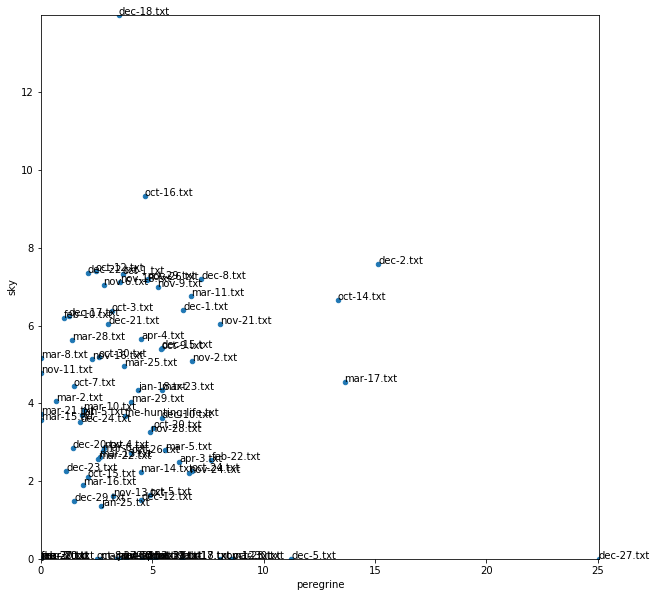

In [35]:
biplot(dtm_meta,'peregrine','sky','fn')

In [36]:
def biplot_groups(df, x_col, y_col, group_col=None, label_col=None, figsize=(10,10)):
    max_x=max(df[x_col])
    max_y=max(df[y_col])
    
    groups = df.groupby(group_col)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group[x_col], group[y_col], marker='o', linestyle='', ms=8, label=name)
        label_point(group[x_col], group[y_col], group[label_col], ax)
        #ax.plot(x=group[x_col],y=group[y_col],kind='scatter',xlim=(0,max_x),ylim=(0,max_y),label="hello")
    ax.legend()
    plt.xlabel(x_col, fontsize=16)
    plt.ylabel(y_col, fontsize=16)

    plt.show()
    

In [37]:
biplot_groups(dtm_meta, 'peregrine','sky')

TypeError: You have to supply one of 'by' and 'level'

In [17]:
dtm_2d = dtm[['said','knew']]
dtm_2d

,said,knew
index,,
Rafaela (1),1.425517,2.375861
Bobby (2),1.534527,0.000000
Emi (3),2.723735,1.167315
Buzzworm (4),3.663004,0.915751
Manzanar (5),0.000000,2.808989
Gabriel (6),1.744186,1.453488
Arcangel (7),3.095975,1.238390
Manzanar (8),0.000000,2.109705
Emi (9),0.600962,0.600962


In [19]:
from scipy.spatial.distance import squareform, pdist
from scipy.stats import zscore

In [ ]:
# Getting distances:
# for more info on pdist: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

#pdist(dtm)
#squareform(pdist(dtm))
#pd.DataFrame(squareform(pdist(dtm)))
#pd.DataFrame(squareform(pdist(dtm)), columns=dtm.index, index=dtm.index)

In [20]:
def make_dist(X_dtm,dist_metric='euclidean',standardize=False):
    distmatrix=pdist(X_dtm,metric=dist_metric)
    return pd.DataFrame(squareform(distmatrix), columns=X_dtm.index, index=X_dtm.index)

In [21]:
dtm_2d_dist = make_dist(dtm_2d)

In [22]:
dtm_2d_dist['Rafaela (1)'].sort_values()

index
Rafaela (1)      0.000000
Gabriel (39)     0.690737
Gabriel (43)     0.944112
Gabriel (6)      0.975870
Emi (27)         1.052079
Buzzworm (48)    1.056083
Gabriel (32)     1.186704
Emi (41)         1.244921
Buzzworm (16)    1.403599
Rafaela (24)     1.420504
                   ...   
Buzzworm (4)     2.671754
Rafaela (38)     2.770707
Manzanar (28)    2.770707
Bobby (26)       2.770707
Manzanar (46)    2.770707
Manzanar (35)    2.770707
Bobby (49)       2.770707
Bobby (12)       3.062393
Buzzworm (37)    3.414294
Buzzworm (31)    3.509791
Name: Rafaela (1), Length: 49, dtype: float64

### N-D Distance

In [25]:
# How many dimensions?
len(dtm.columns)

500

In [26]:
# Distance matrix

dtm_dist = make_dist(dtm)
dtm_dist

index,Rafaela (1),Bobby (2),Emi (3),Buzzworm (4),Manzanar (5),Gabriel (6),Arcangel (7),Manzanar (8),Emi (9),Rafaela (10),...,Bobby (40),Emi (41),Manzanar (42),Gabriel (43),Emi (44),Rafaela (45),Manzanar (46),Arcangel (47),Buzzworm (48),Bobby (49)
index,,,,,,,,,,,,,,,,,,,,,
Rafaela (1),0.000000,22.144770,15.920587,17.787622,22.662788,15.434517,21.860792,19.688150,19.331526,14.738735,...,20.395461,18.887122,20.136278,16.701632,21.358085,20.573854,27.079121,18.831300,23.337301,23.685749
Bobby (2),22.144770,0.000000,19.639985,22.081462,28.199009,19.709471,27.667796,25.877659,21.586473,22.506650,...,18.474976,22.177411,26.187464,21.407115,25.632629,28.856420,31.509716,23.677394,26.621166,25.447331
Emi (3),15.920587,19.639985,0.000000,18.013485,23.195682,13.498067,21.326591,19.446766,16.807735,16.209561,...,17.694028,15.504966,20.877633,15.251444,18.880571,23.105188,26.827342,16.972197,21.255917,23.061148
Buzzworm (4),17.787622,22.081462,18.013485,0.000000,25.847650,17.648744,23.562930,23.062784,20.594507,20.913718,...,21.522805,21.920123,23.578297,19.099972,22.505702,26.519782,29.724153,21.979152,23.335041,26.084474
Manzanar (5),22.662788,28.199009,23.195682,25.847650,0.000000,21.273956,25.595339,19.865264,25.499481,22.582716,...,27.685886,24.791075,21.474247,22.996794,26.706970,27.071501,30.763561,23.135511,28.556169,31.582654
Gabriel (6),15.434517,19.709471,13.498067,17.648744,21.273956,0.000000,21.333574,17.772787,16.836742,16.430009,...,18.215150,16.920279,20.337004,13.916746,18.802929,22.956263,27.272221,17.706201,21.929213,23.419689
Arcangel (7),21.860792,27.667796,21.326591,23.562930,25.595339,21.333574,0.000000,23.028278,24.818323,22.395831,...,26.221204,23.887865,25.113223,22.106210,24.217067,26.078597,30.152929,22.298030,27.099445,29.056228
Manzanar (8),19.688150,25.877659,19.446766,23.062784,19.865264,17.772787,23.028278,0.000000,22.266553,19.442733,...,24.514478,21.543304,19.347676,20.529425,22.934158,24.961035,28.889685,18.984807,25.875027,27.582690
Emi (9),19.331526,21.586473,16.807735,20.594507,25.499481,16.836742,24.818323,22.266553,0.000000,20.159114,...,20.345795,19.524042,23.817225,18.432379,20.540951,25.852478,29.090107,21.103442,23.712268,24.574257


In [ ]:
dtm_dist['Rafaela (1)'].sort_values()

In [ ]:
dtm_dist['Bobby (2)'].sort_values()

In [ ]:
dtm_dist['Manzanar (19)'].sort_values()

In [ ]:
dtm_dist['Manzanar (5)'].sort_values()

## Clustering

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [39]:
# Here it is: in a single line, compute a hierarchical clustering of the DTM

hclust = linkage(dtm,method='complete')
hclust

array([[ 16.        ,  65.        ,  14.88273799,   2.        ],
       [ 17.        ,  88.        ,  21.59919809,   3.        ],
       [ 21.        ,  42.        ,  22.1769423 ,   2.        ],
       [ 74.        ,  89.        ,  23.12267339,   4.        ],
       [  4.        ,  18.        ,  23.30810994,   2.        ],
       [ 40.        ,  91.        ,  24.70046941,   5.        ],
       [ 64.        ,  90.        ,  25.51598435,   3.        ],
       [ 34.        ,  92.        ,  26.69012987,   3.        ],
       [ 25.        ,  56.        ,  26.83921618,   2.        ],
       [ 12.        ,  86.        ,  27.41264123,   2.        ],
       [ 78.        ,  81.        ,  27.43278657,   2.        ],
       [ 51.        ,  93.        ,  27.55611902,   6.        ],
       [ 60.        ,  84.        ,  27.9694268 ,   2.        ],
       [ 41.        ,  95.        ,  28.29212671,   4.        ],
       [ 44.        ,  99.        ,  28.4740074 ,   7.        ],
       [  3.        , 100

In [40]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [41]:
def plot_dendrogram(dtm,linkage_method='complete'):
    hclust = linkage(dtm,method=linkage_method)
    
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title('Hierarchical Clustering Dendrogram (truncated)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    fancy_dendrogram(
        hclust,
        show_leaf_counts=False,  # otherwise numbers in brackets are counts
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,  # to get a distribution impression in truncated branches
        labels=dtm.index,
    )
    plt.savefig('hclust_dendrogram.pdf')
    plt.show()


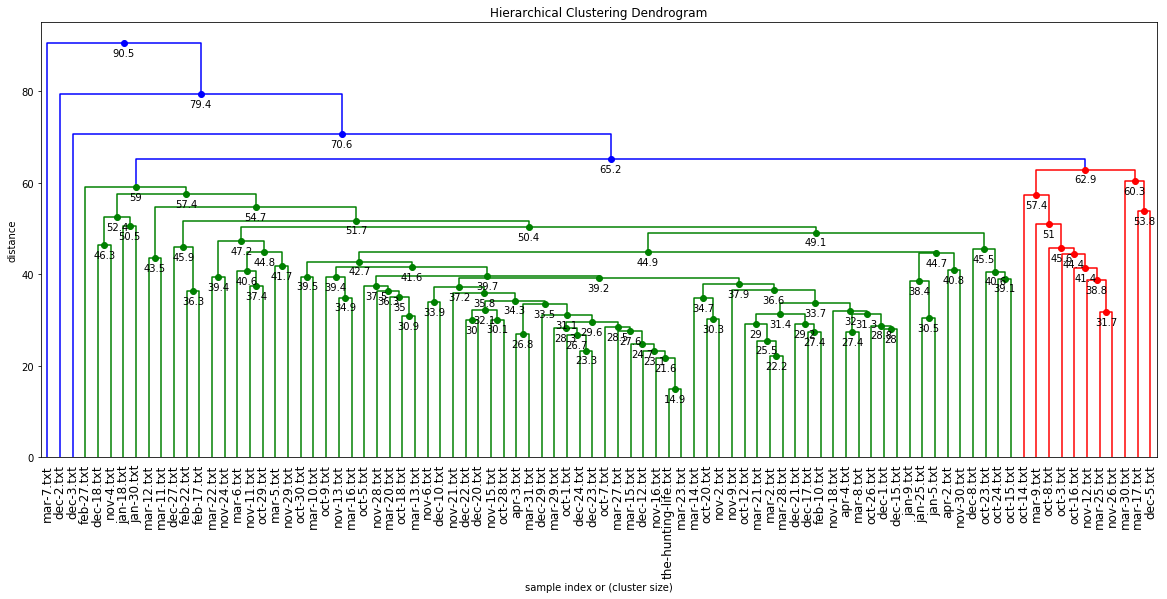

In [42]:
plot_dendrogram(dtm)

In [32]:
# TFIDF function
def to_tfidf(dtm):
    import numpy as np, pandas as pd
    # list of dictionaries
    dtm_tfidf = pd.DataFrame()
    
    for word in dtm.columns:
        # tf
        tf_series = dtm[word]
        
        # idf
        num_docs = len(dtm)
        num_docs_with_word=len(dtm[dtm[word]>0])
        idf=np.log(num_docs/num_docs_with_word)
        
        # tfidf
        tfidf_series = tf_series * idf
        dtm_tfidf[word]=tfidf_series
    
    return dtm_tfidf

In [33]:
dtm_tfidf = to_tfidf(dtm)
dtm_tfidf

,like,could,one,got,know,get,time,back,said,see,...,onto,notes,standing,catch,word,yelled,known,men,stepped,hanging
index,,,,,,,,,,,,,,,,,,,,,
Rafaela (1),0.044090,0.210146,0.0,0.439489,0.512737,0.805729,0.476113,0.165115,0.439489,0.073248,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bobby (2),0.116016,0.000000,0.0,2.680881,0.788495,1.261591,0.394247,0.161583,0.473097,0.315398,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Emi (3),0.136392,0.122916,0.0,0.719770,1.079655,1.559501,0.179942,0.073750,0.839731,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Buzzworm (4),0.144763,0.327851,0.0,1.411636,0.658764,0.564655,1.176364,0.096427,1.129309,0.329382,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Manzanar (5),0.014480,0.133102,0.0,0.000000,0.000000,0.000000,0.433008,0.088734,0.000000,0.108252,...,2.098209,1.190025,1.366510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gabriel (6),0.071928,0.238757,0.0,1.165092,0.627357,0.448112,0.403301,0.091830,0.537735,0.313679,...,0.000000,0.000000,0.000000,0.434281,0.817973,0.492615,0.526854,0.000000,0.000000,0.000000
Arcangel (7),0.127674,0.352081,0.0,0.000000,0.763595,0.000000,0.477247,0.039120,0.954493,0.190899,...,0.000000,0.000000,1.204898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Manzanar (8),0.087001,0.199933,0.0,0.000000,0.000000,0.000000,0.000000,0.066644,0.000000,0.325212,...,1.575870,3.575096,0.000000,0.000000,0.000000,0.000000,0.000000,3.151741,0.000000,0.000000
Emi (9),0.148697,0.189840,0.0,2.038050,0.926386,1.296941,0.370555,0.227809,0.185277,0.370555,...,0.000000,2.036774,0.000000,0.000000,0.845501,2.036774,0.000000,0.000000,0.000000,0.000000


In [34]:
dtm_tfidf.loc['Manzanar (46)'].nlargest(20)

words         8.134824
lips          7.335912
heard         7.267738
year          6.879806
woman         4.911208
saw           4.634847
hanging       4.211927
body          3.870022
wings         3.667956
forth         3.439903
sudden        3.439903
upon          3.439903
concrete      3.439903
smoke         3.233604
everywhere    3.233604
card          3.233604
save          3.233604
onto          3.233604
white         3.089898
van           2.872015
Name: Manzanar (46), dtype: float64

In [35]:
dtm_tfidf.loc['Arcangel (36)'].nlargest(20)

crowd       4.829376
bus         4.625830
hidden      4.625830
poor        4.559647
behind      4.076834
everyone    4.073636
old         4.017840
suitcase    3.821767
orange      3.796073
known       3.298232
forward     3.231402
man         3.085819
card        2.718699
top         2.414688
city        2.154268
young       2.154268
thousand    2.036818
name        1.724079
say         1.662692
future      1.649116
Name: Arcangel (36), dtype: float64

In [36]:
dtm_tfidf.loc['Bobby (49)'].nlargest(20)

hanging    7.484270
orange     6.876732
gets       5.691202
line       5.169739
bad        4.304737
knows      3.827512
lines      3.827512
fast       3.258838
sex        3.258838
cut        2.872933
palms      2.872933
na         2.521752
boy        2.309936
forward    2.276481
looking    2.181710
fire       2.152368
family     2.152368
running    2.152368
figure     1.925863
kind       1.821887
Name: Bobby (49), dtype: float64

In [37]:
dtm_tfidf.loc['Gabriel (6)'].nlargest(20)

story        3.385080
reporter     3.271892
write        2.634271
phone        2.602864
summer       1.990450
afternoon    1.847948
rain         1.697015
hour         1.538673
sex          1.477845
hot          1.456701
downtown     1.385961
stories      1.385961
five         1.376477
living       1.376477
na           1.372302
coffee       1.302842
deal         1.302842
real         1.302454
gon          1.301432
turn         1.226960
Name: Gabriel (6), dtype: float64

In [38]:
dtm_tfidf.loc['Gabriel (17)'].nlargest(20)

interview    5.002623
homeless     4.856450
crazy        2.922022
tried        2.356349
born         2.301944
second       2.092856
person       1.767261
coffee       1.767261
story        1.669727
name         1.494292
kind         1.494292
streets      1.481975
write        1.429321
forget       1.336432
news         1.324012
heard        1.324012
thousand     1.324012
yet          1.263057
hear         1.263057
listening    1.253340
Name: Gabriel (17), dtype: float64

## t-SNE

[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a popular method of [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction). For more information, [see here](https://www.datacamp.com/community/tutorials/introduction-t-sne).

In [39]:
def tsne(datadf,df_dist=None,n_components=2,resultdf=None):
    if df_dist is None: df_dist=make_dist(datadf)
    m_dist=df_dist.values
    from sklearn.manifold import TSNE
    model = TSNE(n_components=n_components, random_state=0)
    fit = model.fit_transform(m_dist)
    from collections import defaultdict
    newcols=defaultdict(list)
    for i,word in enumerate(datadf.index):
        for ii,xx in enumerate(fit[i]):
            newcols['tsne_V'+str(ii+1)] += [xx]
    if resultdf is None: resultdf=pd.DataFrame(index=datadf.index)
    for k,v in list(newcols.items()): resultdf[k]=v
    return resultdf

In [40]:
dtm_tsne = tsne(dtm)

In [41]:
dtm_tsne_meta = dtm_tsne.join(dtm_meta)

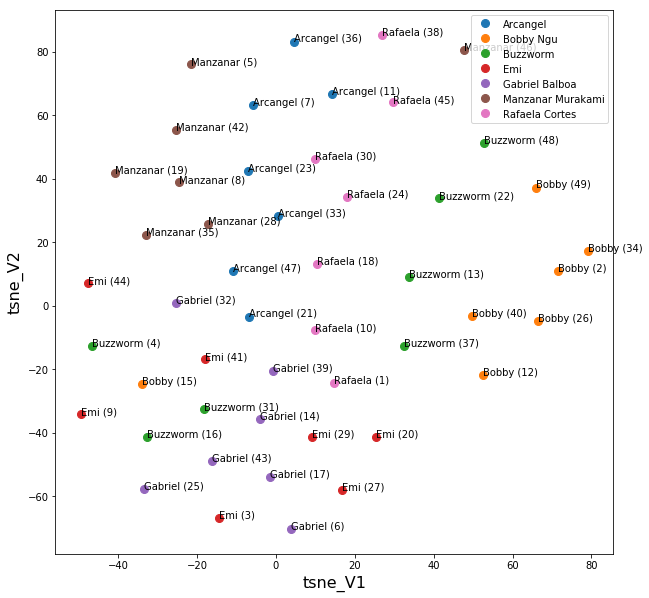

In [42]:
biplot_groups(dtm_tsne_meta, 'tsne_V1', 'tsne_V2', 'narrator', 'label')